In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [3]:
psi = 0

In [4]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [5]:
dx = 7.5 
dy = 7.5
dt = 1

In [6]:
maxFrequency = 4.0 
# Approximate max  frequency to consider (converted to max wavenumber below) [rad/sec]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
# % wavenumber resolution of spectrum in each spatial window 
# (not strictly true if dx ~= dy, but value only needs to be approximate in practice)

kW = 1*dk
# Half width of wavenumbers bins [rad/m]

dk

0.012503851357571316

In [7]:
wavenumbers = np.arange(3 * dk, 0.305, dk)

In [8]:
wavenumbers

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [9]:
Nt, Nx, Ny = eta.shape

In [10]:
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [11]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [12]:
Norm = dKx*dKy*dW

In [13]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [14]:
power_Spectrum.shape

(1200, 67, 67)

In [15]:
g = 9.81
h = 1000

def w_dr(kx, ky, Ux, Uy):
    return np.sqrt(g * np.sqrt( kx **2 + ky **2 ) * np.tanh(h * np.sqrt( kx **2 + ky **2 ))) + kx * Ux + ky * Uy

In [16]:
from matplotlib.colors import ListedColormap

In [17]:
%matplotlib widget
# makes plots interactive

In [18]:
%matplotlib inline

In [19]:
Uk[:,0].shape

(680,)

In [20]:
Uk

array([[0.05494615, 0.05494615, 0.05494615, ..., 0.05494615, 0.05494615,
        0.05494615],
       [0.05745544, 0.05745544, 0.05745544, ..., 0.05745544, 0.05745544,
        0.05745544],
       [0.05994452, 0.05994452, 0.05994452, ..., 0.05994452, 0.05994452,
        0.05994452],
       ...,
       [0.63260879, 0.63260879, 0.63260879, ..., 0.63260879, 0.63260879,
        0.63260879],
       [0.63295845, 0.63295845, 0.63295845, ..., 0.63295845, 0.63295845,
        0.63295845],
       [0.63330752, 0.63330752, 0.63330752, ..., 0.63330752, 0.63330752,
        0.63330752]])

In [21]:
k

array([0.01  , 0.0105, 0.011 , 0.0115, 0.012 , 0.0125, 0.013 , 0.0135,
       0.014 , 0.0145, 0.015 , 0.0155, 0.016 , 0.0165, 0.017 , 0.0175,
       0.018 , 0.0185, 0.019 , 0.0195, 0.02  , 0.0205, 0.021 , 0.0215,
       0.022 , 0.0225, 0.023 , 0.0235, 0.024 , 0.0245, 0.025 , 0.0255,
       0.026 , 0.0265, 0.027 , 0.0275, 0.028 , 0.0285, 0.029 , 0.0295,
       0.03  , 0.0305, 0.031 , 0.0315, 0.032 , 0.0325, 0.033 , 0.0335,
       0.034 , 0.0345, 0.035 , 0.0355, 0.036 , 0.0365, 0.037 , 0.0375,
       0.038 , 0.0385, 0.039 , 0.0395, 0.04  , 0.0405, 0.041 , 0.0415,
       0.042 , 0.0425, 0.043 , 0.0435, 0.044 , 0.0445, 0.045 , 0.0455,
       0.046 , 0.0465, 0.047 , 0.0475, 0.048 , 0.0485, 0.049 , 0.0495,
       0.05  , 0.0505, 0.051 , 0.0515, 0.052 , 0.0525, 0.053 , 0.0535,
       0.054 , 0.0545, 0.055 , 0.0555, 0.056 , 0.0565, 0.057 , 0.0575,
       0.058 , 0.0585, 0.059 , 0.0595, 0.06  , 0.0605, 0.061 , 0.0615,
       0.062 , 0.0625, 0.063 , 0.0635, 0.064 , 0.0645, 0.065 , 0.0655,
      

In [22]:
np.sqrt(kx**2+ky**2) 

NameError: name 'kx' is not defined

In [ ]:
w_values.shape

In [ ]:
# Create a meshgrid for kx and ky
kx, ky = np.meshgrid(Kx, Ky)

# Assuming Ux is an array with the same shape as kx and ky
Ux_values = Uk[:,0]

# Calculate w values using the function
w_values = w_dr(kx, ky, Ux_values[:, np.newaxis, np.newaxis], 0)

# Flatten the arrays
kx_flat = kx.flatten()
ky_flat = ky.flatten()
w_values_flat = w_values.flatten()

# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Dispersion Relation Surface")

# disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()


In [ ]:
np.max(power_Spectrum)

In [ ]:
count_greater_than_big = np.sum(power_Spectrum >= np.max(power_Spectrum)*0.2)

In [ ]:
count_greater_than_big

In [ ]:
indices_greater_than_big = np.where(power_Spectrum >= np.max(power_Spectrum)*0.2)
indices_greater_than_big

In [ ]:
points = list(zip(indices_greater_than_big[0], indices_greater_than_big[1], indices_greater_than_big[2]))

# Print the points
print("Points where values are greater than 0.2:")
for point in points:
    print(f"({point[0]}, {point[1]}, {point[2]})")

In [ ]:
points
# tiplet indices of each 

In [ ]:
kx[0,:]

In [ ]:
ky[:,0]

In [ ]:
w

In [ ]:
w_new = spec3d.w
w_new

In [ ]:
points

In [ ]:
points[0]

In [ ]:
kx_trip = []
ky_trip = []
w_trip = []

for i in range(len(points)):
    kx_trip.append( kx[0,:] [ points[i][1] ])
    ky_trip.append( ky[:,0] [ points[i][2] ])
    w_trip.append( w_new [  points[i][0] ])

In [ ]:
count_greater_than_big/2

In [ ]:
np.array( w_trip )[count_greater_than_big//2:]

In [ ]:
# Create a meshgrid for kx and ky
kx, ky = np.meshgrid(Kx, Ky)

# Assuming Ux is an array with the same shape as kx and ky
Ux_values = Uk[:,0]

# Calculate w values using the function
w_values = w_dr(kx, ky, Ux_values[:, np.newaxis, np.newaxis], 0)

# Flatten the arrays
kx_flat = kx.flatten()
ky_flat = ky.flatten()
w_values_flat = w_values.flatten()

# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, alpha=0.3, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Triplets Dispersion Relation Surface")

ax.scatter( np.array(kx_trip) [count_greater_than_big//2:], np.array(ky_trip) [count_greater_than_big//2:], 
           np.array( w_trip )[count_greater_than_big//2:], color='red', marker='o', s=8)

# disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()

In [ ]:
np.array(kx_trip) [count_greater_than_big//2:]


In [ ]:
np.array(ky_trip) [count_greater_than_big//2:]

In [ ]:
np.array( w_trip )[count_greater_than_big//2:]

In [ ]:
spec3d.Nt = 1200

spec3d.dkx = spec3d.kx[64]-spec3d.kx[63]

In [ ]:
def estimate_dispersion_cone(self, h, Umax, kmin=0.04, kmax=0.5, plot_it=False):
        '''
        Estimate dispersion cone. It returns a representation of the dispersion cone where the energy is high enough

        Algorithm: 
        - Pass to polar coordinates 
        - apply dispersion filter to avoid using aliased data etc. 
        - select part of arc where there is energy (>0.1max)
        - define relevant k based on upper and lower bounds of k on the grid (close to kmin, kmax provided)
        - select part of spectrum representing relevant theta and k values 
        - loop through theta:
            - apply gaussian blur
            - find peak of w for for all k of interest along the given angle
        
        

        Parameters:
        -----------
                    input       
                            h       float
                                    waterdepth
                            Umax    float
                                    maximum expected current 
                            kmin    float
                                    lower boundary for wave numbers relevant for defining cone, default 0.04
                            kmax    float
                                    upper boundary for wave numbers relevant for defining cone, default 0.3
                            plot_it bool
                                    if data and cone slice should be shown

                    output:
                            k_rel       array
                                        vector of wave numbers for which the dispersion cone is defined
                            theta_rel  array
                                        vector of azimuth angles for which the dispersion cone is defined
                            w compo. of disp_cone   2d array
                                        angular frequency for each combinatin of wave numbers and angle 
        '''
        w_upper = self.w[self.Nt//2:]
        half_spec = np.flip(self.spectrum()[1:self.Nt//2+1,:,:], axis=0)
        filtered_half_spec = gaussian_filter(half_spec, (0.5,0.3,0.3))

        #k, theta, spec_pol = polar_coordinates.cart2cylindrical(w_upper, self.kx, self.ky, half_spec, Ntheta=100)     
        k, theta, spec_pol = polar_coordinates.cart2cylindrical(w_upper, self.kx, self.ky, filtered_half_spec, Ntheta=100)            
        spec_pol = np.abs(spec_pol)
        
        # dispersion filter

        from radar_tools import dispersion_filter, filter_core
        mask = dispersion_filter.w_k_theta_filter(w_upper, k, theta, Umax, h, w_min=0.6)
        masked_spec_pol = mask*spec_pol
        #masked_spec_pol = spec_pol
        
        # select arc with energy          
        theta_spec = np.sum(np.sum(masked_spec_pol, axis=0), axis=0)        
        rel_indices = np.argwhere(theta_spec>0.2*np.max(theta_spec)).transpose()[0]        
        theta_rel = theta[rel_indices]
        # k_relevant
        k_min_ind = np.argmin(np.abs(k - kmin))
        k_max_ind = np.argmin(np.abs(k - kmax))
        k_rel = k[k_min_ind:k_max_ind+1]
        # empty disp cone
        w_matrix = np.zeros((len(k_rel), len(theta_rel)))
        rel_spec = masked_spec_pol[:,k_min_ind:k_max_ind+1,rel_indices]
        min_dw = 4* np.sqrt(self.dkx*9.81)
        ww, kk = np.meshgrid(w_upper, k_rel, indexing='ij')

        
        def get_U_eff(k):
            Nk = len(k)
            z = np.linspace(-100,0,100)
            U = np.exp(0.5*z) + 0.05
            UU = np.outer(np.ones(Nk), U)
            kk, zz = np.meshgrid(k, z, indexing='ij')
            return 2*k*np.sum(UU*np.exp(2*kk*zz), axis=1) * np.abs(z[1]-z[0])

    
        for i in range(0, len(theta_rel)):
            input_spec = rel_spec[:,:,i]#convolutional_filters.apply_Gaussian_blur(rel_spec[:,:,i])
            max_input_spec = np.outer(np.ones(len(w_upper)), np.max(input_spec, axis=0) )
            # filtering relative to the power along w-axis otherwise spectral noise in the center moves the cone to the center
            input_spec = np.where(input_spec>0.1*max_input_spec, input_spec, 0)
            pow = 1#0.3
            pow2 = 1
            w_peaks = (np.sum(input_spec**pow * ww**pow2, axis=0)/np.sum(input_spec**pow, axis=0))**(1./pow2)
            w_matrix[:,i] = savgol_filter(w_peaks, 31, 3)#w_peaks
            
            if plot_it:
                import pylab as plt
                scaled_2d = spec_pol[:,k_min_ind:k_max_ind,i]/np.max(spec_pol[:,k_min_ind:k_max_ind,i])
                #plotting_interface.plot_k_w_spec(k_rel, w_upper, np.log10(scaled_2d).T, extent=[0.03, 0.35, 0.5, 1.9])
                plotting_interface.plot_k_w_spec(k_rel, w_upper, (input_spec).T, extent=[0.03, 0.35, 0.5, 1.9])
                #plotting_interface.plot(k_rel, w_peaks)
                #plt.plot(k_rel, w_peaks, 'k-.')
                plt.plot(k_rel, savgol_filter(w_peaks, 31, 3), 'w')
                plt.plot(k_rel, np.sqrt(9.81*k_rel) + k_rel*get_U_eff(k_rel)*np.cos(-theta_rel[i]),'--', color='darkorange')
                #plt.xlim(0.055, 0.085)
                #plt.ylim(0.65, 0.95)
                #plotting_interface.savefig('images/disp_rel_est_0_detail_above.pdf'.format(i))
                plotting_interface.show()
        return k_rel, theta_rel, w_matrix

In [ ]:
k_rel, theta_rel, w_matrix = estimate_dispersion_cone(spec3d, h=1000, Umax=1, kmin=0.04, kmax=0.5, plot_it=True)

In [ ]:
k_rel.shape

In [ ]:
theta_rel.shape

In [ ]:
w_matrix.shape

In [ ]:
jx = []
jy = []
wj = []

for i in range(len(theta_rel)):
    
    jx.append( k_rel * np.cos( theta_rel[i] ) )
    jy.append( k_rel * np.sin( theta_rel[i] ) )  
    
    wj.append( w_matrix[:,i] )

In [ ]:
wj[0]

In [ ]:
# Create a meshgrid for kx and ky
kx, ky = np.meshgrid(Kx, Ky)

# Assuming Ux is an array with the same shape as kx and ky
Ux_values = Uk[:,0]

# Calculate w values using the function
w_values = w_dr(kx, ky, Ux_values[:, np.newaxis, np.newaxis], 0)

# Flatten the arrays
kx_flat = kx.flatten()
ky_flat = ky.flatten()
w_values_flat = w_values.flatten()

# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, alpha=0.3, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Triplets Dispersion Relation Surface")

for i in range(len(theta_rel)):
    ax.scatter( jx[i], jy[i], wj[i], color='red', marker='o', s=2)
    

#disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()

# Consider 2 triplets

In [ ]:
kx_2 = jx_flat
ky_2 = jy_flat
w_2 = wj_flat
# try do it with all of triplets in above diagram 

In [ ]:
kx_2 = np.array(kx_trip) [count_greater_than_big//2:]
ky_2 = np.array(ky_trip) [count_greater_than_big//2:]
w_2 = np.array( w_trip )[count_greater_than_big//2:]

In [ ]:
kx_2 = np.array([ jx[0][50], jx[0][100]])
ky_2 = np.array([ jy[0][50], jy[0][100]])
w_2 = np.array([ wj[0][50], wj[0][100]])

In [ ]:
kx_2

In [ ]:
ky_2

In [ ]:
w_2

In [ ]:
 np.sqrt(kx_2**2+ky_2**2)

In [ ]:
k[355]

In [ ]:
k[655]

In [ ]:
Uk[:,0][335]
# correct U

In [ ]:
Uk[:,0][655]
# correct U

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Define the function Q(Ux, Uy=0) for each element in kx_2
def Q(Ux, kx, ky, w):
    Uy = 0  # Fixed value for Uy
    return np.sum( (w - np.sqrt(9.81 * np.sqrt(kx**2 + ky**2)) - kx * Ux - ky * Uy)**2)

# Initialize empty arrays to store optimized values
Ux_optimized = np.zeros_like(kx_2)
Uy_optimized = np.zeros_like(ky_2)

# Optimize Ux separately for each element in kx_2
for i in range(len(kx_2)):
    result = minimize(Q, x0=0, args=(kx_2[i], ky_2[i], w_2[i]), method='BFGS')
    Ux_optimized[i] = result.x
    Uy_optimized[i] = 0

print("Optimized Ux:", Ux_optimized)
print("Optimized Uy:", Uy_optimized)


In [ ]:
plt.scatter( np.sqrt(kx_2**2 + ky_2**2), np.array(Ux_optimized), label='using trips', s = 5)
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.xlabel("k")
plt.ylabel("U")

plt.xlim(0,0.35)
plt.ylim(0,1)

In [ ]:
k_trip = np.sqrt(kx_2**2 + ky_2**2)
w = np.array(Ux_optimized),

In [ ]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
param, covariance = curve_fit(power_law_function, k_trip, w)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(k_trip), max(k_trip), len(k_trip))
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(k_trip, w, label='Triplets $\omega$ ', s=20, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [ ]:
Q(0.6267807247345579)

# Try to do it for all triplets

In [ ]:
np.sqrt(jx**2+jy**2)

In [ ]:
kx_new = jx.flatten()
ky_new = jy.flatten()
w_new = wj.flatten()

In [ ]:
w_new.shape

In [ ]:
def w0(kx, ky):
    return np.sqrt( 9.81 * np.sqrt( kx**2 + ky**2 ) )

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Define constants
g = 9.81

# Define the cost function
def cost_function(params, kx, ky, w):
    Ux, Uy = params
    k = np.sqrt(kx**2 + ky**2)
    w0 = np.sqrt(g * np.sqrt(kx**2 + ky**2))
    return np.sum((w - w0 - kx*Ux - ky*Uy)**2)

# Perform optimization for each triplet
results = []
for i in range(len(kx_new)):
    triplet_cost_function = lambda params: cost_function(params, kx_new[i], ky_new[i], w_new[i])
    initial_guess = [U[:len(kx_new)], 0]  # Initial guess for Ux and Uy
    result = minimize(triplet_cost_function, initial_guess, method='L-BFGS-B')
    results.append(result.x)

# Extract Ux and Uy values for each triplet
Ux_values, Uy_values = zip(*results)

# Print or use the results as needed
print("Ux values:", Ux_values)
print("Uy values:", Uy_values)


In [ ]:
Ux = np.array(Ux_values)
Uy = np.array(Uy_values)

In [ ]:
k_new = np.sqrt(kx_new**2+ky_new**2)

In [ ]:
plt.plot(k_new,Ux)
#plt.plot(k_new,Uy)
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')


plt.grid(True)

In [ ]:
# Remember that w0 is constant for all angles

In [ ]:
w0 = []
k_new = np.sqrt( jx**2 + jy **2 ) 

for i in range(len(theta_rel)):
    w0.append(np.sqrt( 9.81 * k_new[i] )  )

In [ ]:
# Given data
w0 = w0[1]
k = k_new[0][:90]
N1 = np.prod(jx.shape)

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Calculate k_i
#k np.sqrt(jx**2 + jy**2)

# Define the objective function to be minimized
def obj_function(U, k, wj, w0):
    return np.sum((wj - w0 - k * U)**2)

# Iterate over each k and find the corresponding U
U_values = []
for ki_value in k:
    # Define the minimization problem
    minimization_result = minimize( obj_function , x0=0, args=(ki_value, wj, w0),method='L-BFGS-B')  
    
    # Store the optimal U value
    U_optimal = minimization_result.x[0]
    U_values.append(U_optimal)

# Print or use U_values as needed
print("Optimal U values for each k:", U_values)


In [ ]:
plt.plot(k, np.array( U_values))

plt.grid(True)
plt.xlabel('k')
plt.ylabel('U')

In [ ]:
np.prod(jx.shape)

In [ ]:
jx.shape

In [ ]:
k

In [ ]:
w0 = []
k = np.sqrt( jx**2 + jy **2 ) 

for i in range(len(theta_rel)):
    w0.append(np.sqrt( 9.81 * k[i] )  )
    

In [ ]:
w0 = np.array(w0)
w0.shape

In [ ]:
for i in range(len(theta_rel)):
    plt.plot(k[i], w0[i])

plt.grid(True)
plt.xlabel('k')
plt.ylabel('$\omega$')
plt.title("Dispersion Relation w0")

In [ ]:
w0

In [ ]:
theta_rel

In [ ]:
jx = np.array(jx)
jy = np.array(jy)
wj = np.array(wj)

In [ ]:
jx_flat = jx.flatten()
jy_flat = jy.flatten()
wj_flat = wj.flatten()

In [ ]:
# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, alpha=0.3, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Triplets Dispersion Relation Surface")

ax.scatter( jx_flat,  jy_flat, wj_flat, color='blue', marker='o', s=2)
    

#disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()

In [ ]:
jx_flat = jx.flatten()

In [ ]:
def plot_disp_relation_and_points_at_theta(spec_theta,  h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''

    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.plot(disp_r, disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return disp_r, disp_ww_for_theta
    
    

In [ ]:
disp_r, disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, h=1000, z = z, U=U, psi = 0)

In [ ]:
theta_rel

In [ ]:
# lets do it at theta = -1.34280431

In [ ]:
theta_rel[13]

In [ ]:
disp_r, disp_ww_for_theta = plot_disp_relation_and_points_at_theta(theta_rel[13], h=1000, z = z, U=U, psi = 0)

plt.scatter(np.sqrt(jx[13]**2+jy[13]**2),wj[13], color = 'red', s = 2)

plt.plot(disp_r, np.sqrt(9.81*disp_r) + + disp_r* optimized_U2,  color = 'green')

In [ ]:
k_TRIP = np.sqrt( jx[13]**2+jy[13]**2 )
w_TRIP = wj[13]

In [ ]:
k_trip = k_TRIP[:90]
w_trip = w_TRIP[:90]

In [ ]:
w_0 = np.sqrt( 9.81 * k_trip )

In [ ]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.zeros(len(k_trip))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=(w_trip,w_0 ,k_trip))

# Optimized U values
optimized_U1 = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U1)

In [ ]:
plt.scatter(k_trip, optimized_U1, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.scatter(disp_r, optimized_U2, label='Optimized U ', color='green')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

In [ ]:
disp_r, disp_ww_for_theta

In [ ]:
w_0 = np.sqrt( 9.81 * disp_r )

In [ ]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.linspace(0.01, 0.6, len(disp_r))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=(disp_ww_for_theta, w_0 , disp_r))

# Optimized U values
optimized_U2 = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U2)

In [ ]:
plt.scatter(disp_r, optimized_U2, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

In [ ]:
filtered_half_spec[i,:,:].shape

In [ ]:
spec3d.kx[64]-spec3d.kx[63]

In [ ]:
aa

In [ ]:
spec3d.Nt = 1200

In [ ]:
spec3d.Nt

In [ ]:
spec3d.w[spec3d.Nt//2:].shape

In [ ]:
k, theta, spec_pol = polar_coordinates.cart2cylindrical(w_upper, self.kx, self.ky, filtered_half_spec, Ntheta=100)           

In [ ]:
half_spec = np.flip(spec3d.spectrum()[1:spec3d.Nt//2+1,:,:], axis=0)
half_spec.T.shape

In [ ]:
filtered_half_spec = gaussian_filter(half_spec, (0.5,0.3,0.3))
filtered_half_spec.shape

In [ ]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [ ]:
# slice along kx = 0
zero_indices = np.where( np.array(kx_trip) [47:] ==0 )
zero_indices

In [ ]:
ky_sliced = np.array(ky_trip) [47:] [zero_indices]
ky_sliced

In [ ]:
w_sliced = np.array(w_trip) [47:] [zero_indices]
w_sliced

In [ ]:
kx

In [ ]:
kx[:,33]

In [ ]:
ky[:,33]

In [ ]:
w_values.shape

In [ ]:
def sliced_at_0(ky):
    g = 9.81
    h = 1000
    return np.sqrt( g * np.abs(ky) * np.tanh( h * np.abs(ky)))

In [ ]:
ky_sliced

In [ ]:
w_sliced

In [ ]:
plt.scatter(ky_sliced, w_sliced, color = 'red', s=2)

kv = np.linspace(0.001, 0.4, 100)
plt.plot(kv, sliced_at_0(kv) )

plt.grid(True)
plt.xlabel("ky")
plt.ylabel("w")

#plt.xlim(0.05,0.1)
#plt.ylim(0.6,1)

In [ ]:
np.array([sliced_at_0(0.05001541), sliced_at_0(0.06251926), sliced_at_0(0.07502311), sliced_at_0(0.08752696)])

In [ ]:
(0.7696902 + 0.77492619 + 0.78016218 + 0.78539816 + 0.80110613)/5

In [ ]:
(0.83775804 + 0.84299403 + 0.86393798 + 0.87440996 + 0.89011792)/5

In [ ]:
(0.91106187 + 0.94771378)/2

In [ ]:
ky_trip = np.array([0.05001541, 0.06251926, 0.07502311, 0.08752696])
w_trip = np.array([0.70046497, 0.782256572, 0.861843586, 0.9293878250000001])

In [ ]:
plt.scatter(ky_trip, w_trip, color = 'red', s=20, label="Trips")

kv = np.linspace(0.001, 0.4, 100)
plt.plot(kv, sliced_at_0(kv) , label='actual disp relation at slice kx=0')

plt.grid(True)
plt.xlabel("ky")
plt.ylabel("w")

plt.plot(kv, np.sqrt( 9.81 * kv), color = 'green')

plt.legend()

In [ ]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
param, covariance = curve_fit(power_law_function, ky_trip, w_trip)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(ky_trip), max(ky_trip), len(ky_trip))
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(ky_trip, w_trip, label='Triplets $\omega$ ', s=20, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [ ]:
w_0 = np.sqrt( 9.81 * ky_trip)
w_0

In [ ]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = [0.2, 0.24, 0.26, 0.29]

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=(w_trip, w_0 ,ky_trip))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

In [ ]:
plt.scatter(ky_trip, optimized_U, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

In [ ]:
# when kx = 0 then w_0 is the same as the dispersion surface altered by current 
# need to try another slice where theyre not the same and see if it works to get good velocities

In [ ]:
# try remove theta dependence and find velocity at each slice of theta 

# remove it being wrong because at different theta values there are different dispersion relations

In [388]:
# psi = 0
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

# psi = 30
# f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_70_0_surf3d.hdf5', 'r')

In [389]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [390]:
# with psi = 0
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")

# with psi = 30
# surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_70_0_surf3d.hdf5")

spec3d = surf3d.define_SpectralAnalysis()

In [391]:
eta_flipped = np.transpose( np.flip(eta, axis= 2) , (1, 2, 0))
eta_flipped.shape

(67, 67, 1200)

In [392]:
eta = eta_flipped
eta.shape

(67, 67, 1200)

In [393]:
dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
dk

0.012503851357571316

In [394]:
dx = 7.5 
dy = 7.5
dt = 1

In [395]:
Nx, Ny, Nt = eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [396]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]
Norm = dKx * dKy * dW

In [397]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# High Pass Filter

In [398]:
I_0 = power_Spectrum
w_cut = 0.03 * 2*np.pi

In [399]:
# Create a boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [400]:
I_1 = np.where(mask[ None, None,:], I_0, 0)

# Energy Threshold Feature 

In [401]:
P = np.max(I_1) / 2000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [402]:
I_2 = np.where(condition[:, :, None], I_1, 0)

# Peak Identification

In [403]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [404]:
def identification(kx, ky, ratio=10., prominence=1e5, distance=5):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)
        order = np.flip(np.argsort(stats["prominences"]))

        values = []

        if len(peaks) == 1:
            values.append(w[peaks[0]])
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            for i, j in zip(order[:-1], order[1:]):
                if stats["prominences"][i] >= ratio * stats["prominences"][j]:
                    values.append(w[peaks[i]])
                    wj[kx,ky] = w[peaks[i]]
                    
#        return {
#            "values": values,
#            "order": order,
#            "peaks": peaks,
#            "stats": stats,
#        }
    
    return wj 
    # rteurns 2d array wj 
    # it will al be 0 if there are no prominent peaks 
    # Otherwise it will have the w value of the singular prominent peak and the ret will be 0 

In [405]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(identification(kx, ky, ratio=10., prominence=1e5, distance=15))

In [406]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

In [407]:
w0 = w0_2D[w0_2D != 0]

In [408]:
nonzero_indices = np.nonzero(w0_2D)

In [409]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

In [410]:
kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [411]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww, kk, th

In [412]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

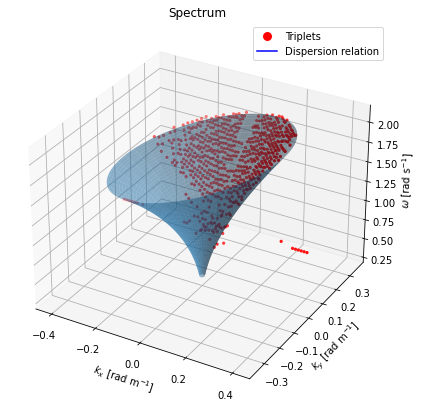

In [413]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip, -ky_trip, w0, color = "red", s = 5)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')

kx, ky, ww, kk, th = plot_disp_shell(ax, h=1000, z=z, U=U, psi=0)

# Create legend manually with a dot for 'Triplets'
legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Triplets'),
    mlines.Line2D([0], [0], color='blue', label='Dispersion relation')
]

# Create legend
ax.legend(handles=legend_elements)
 
# show plot
plt.show()

In [414]:
kx_2D, ky_2D= np.meshgrid(Kx, Ky, indexing='ij')

In [415]:
kx_2D.shape

(67, 67)

## 1) Use Initial Guess (0.1,0.1)

In [512]:
def find_velocity(kx,ky):
    # kx and ky are the indices 
    def objective_funct(U):
        Ux, Uy = U 
        return ( w0_2D[kx, ky] - np.sqrt(9.81*np.sqrt(Kx[kx]**2 + Ky[ky]**2)) - Kx[kx]*Ux - Ky[ky]*Uy )**2

    initial_guess = [0.1,0.1]
    
    result = minimize(objective_funct, initial_guess, method='BFGS')
    
    # Extract the optimized values of Ux and Uy
    Ux_optimized, Uy_optimized = result.x
    
    return Ux_optimized, Uy_optimized, np.sqrt(Kx[kx]**2 + Ky[ky]**2), result.fun

In [513]:
U_x = []
U_y = []
k_vals = []
Q = []

for i in range(len(Kx)):
    for j in range(len(Ky)):
        
        if w0_2D[i,j] < 0.2:
            pass
        
        else:
            U_x.append( find_velocity(i,j)[0] ) 
            U_y.append( find_velocity(i,j)[1] )
            k_vals.append( find_velocity(i,j)[2] )
            Q.append( find_velocity(i,j)[3] )

(0.0, 1.0)

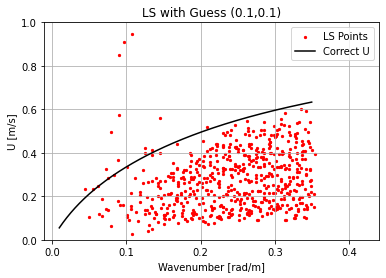

In [525]:
plt.scatter(k_vals, np.sqrt((np.array(U_x))**2+(np.array(U_y))**2), label='LS Points', color = 'red', s = 5)
plt.plot(k, Uk[:,0], label='Correct U', color = 'black')

plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("LS with Guess (0.1,0.1)")

plt.grid(True)
plt.legend()
plt.ylim(0,1)

## 2) Initial Guess is (0.5, 0.1)

In [527]:
def find_velocity(kx,ky):
    # kx and ky are the indices 
    def objective_funct(U):
        Ux, Uy = U 
        return ( w0_2D[kx, ky] - np.sqrt(9.81*np.sqrt(Kx[kx]**2 + Ky[ky]**2)) - Kx[kx]*Ux - Ky[ky]*Uy )**2

    initial_guess = [0.5,0.1]
    
    result = minimize(objective_funct, initial_guess, method='BFGS')
    
    # Extract the optimized values of Ux and Uy
    Ux_optimized, Uy_optimized = result.x
    
    return Ux_optimized, Uy_optimized, np.sqrt(Kx[kx]**2 + Ky[ky]**2), result.fun

In [528]:
U_x = []
U_y = []
k_vals = []
Q = []

for i in range(len(Kx)):
    for j in range(len(Ky)):
        
        if w0_2D[i,j] < 0.2:
            pass
        
        else:
            U_x.append( find_velocity(i,j)[0] ) 
            U_y.append( find_velocity(i,j)[1] )
            k_vals.append( find_velocity(i,j)[2] )
            Q.append( find_velocity(i,j)[3] )

(0.0, 1.0)

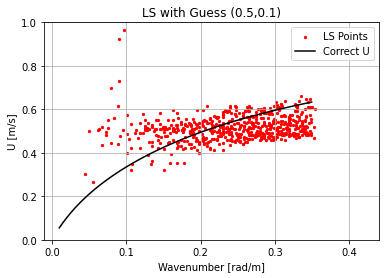

In [530]:
plt.scatter(k_vals, np.sqrt((np.array(U_x))**2+(np.array(U_y))**2), label='LS Points', color = 'red', s = 5)
plt.plot(k, Uk[:,0], label='Correct U', color = 'black')

plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("LS with Guess (0.5,0.1)")

plt.grid(True)
plt.legend()
plt.ylim(0,1)

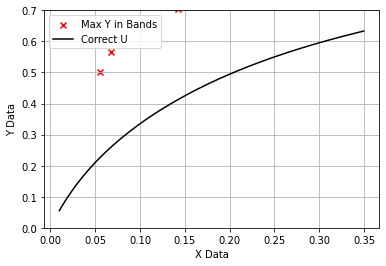

In [449]:
# Step 1: Filter data where y < 1
filtered_data = x[y < 1]
filtered_y = y[y < 1]  # Filter y using the same condition

# Step 2: Divide x data into bands of width 0.01
band_width = 0.01
bins = np.arange(0.05, 0.35, band_width)

# Step 3: Find the value of x where y is maximum for each band
x_max_values = []
y_max_values = []
for i in range(len(bins) - 1):
    band_mask = (filtered_data >= bins[i]) & (filtered_data < bins[i + 1])
    x_band = filtered_data[band_mask]
    y_band = filtered_y[band_mask]  # Use the filtered_y array
    
    if len(y_band) == 0:
        pass
    else:
        max_value_index = np.argmax(y_band)
        if len(y_band) > 0:
            y_max_values.append(y_band[max_value_index])
            x_max_values.append(x_band[max_value_index])

# Step 4: Plot the results
#plt.scatter(x, y, label='Original Data', alpha=0.5)
#plt.scatter(filtered_data, filtered_y, color='r', label='Filtered Data', alpha=0.5)
plt.scatter(x_max_values, y_max_values, color='red', label='Max Y in Bands', marker='x')
plt.plot(k, Uk[:,0], label='Correct U', color = 'black')

plt.xlabel('X Data')
plt.ylabel('Y Data')
plt.grid(True)
plt.legend()
plt.ylim(0,0.7)
plt.show()

In [480]:
def fpow(x, a, b, c):
    return a*x**b+c

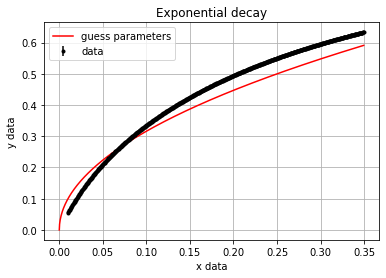

In [486]:
# plot the raw data
plt.errorbar(k, Uk[:,0], yerr=0, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('x data')
plt.ylabel('y data')


# initial guess
pars0 = (1, 1/2, 0)

# overlay exponential 

x = np.linspace(0, max(k), 1000)

plt.plot(x, fpow(x,*pars0), color = 'red', label = 'guess parameters')

plt.legend();
plt.title("Exponential decay");

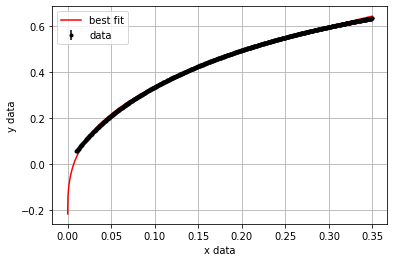

In [489]:
# perform fitting

popt, pcov = curve_fit( fpow, k, Uk[:,0], absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
b_opt = popt[1]
c_opt = popt[2]

# plot data
plt.errorbar(k, Uk[:,0], yerr=0, fmt=".", color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(0, max(k), 1000)
y_fit = fpow(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")


plt.grid(True)
plt.xlabel("x data")
plt.ylabel("y data")
plt.legend();

In [492]:
c_opt

-0.21649356842577225

In [313]:
j = []

In [314]:
len(j)

0

In [280]:
ind = np.where(np.array(Q) > 1*10**-18)

In [281]:
ind[0].shape

(408,)

(0.0, 1.0)

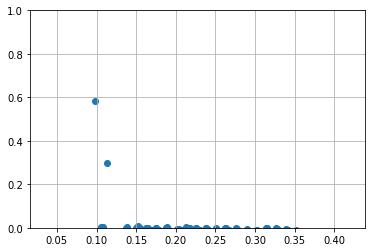

In [282]:
plt.scatter(np.array(k_vals)[ind[0]], np.array(U_x)[ind[0]])

plt.grid(True)
plt.ylim(0,1)